In [229]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Configure image format to be ‘svg’
%config InlineBackend.figure_format = 'svg'

# allow visuals to render within notebook
%matplotlib inline 

In [230]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1. Read in the "daily_per_station" dataframe csvs previously generated

In [231]:
daily_per_station_2019 = pd.read_csv('daily_per_station_2019.csv')
print(daily_per_station_2019.shape)
display(daily_per_station_2019.head(2))
daily_per_station_2019.tail(2)

(27512, 20)


,COMPLEX_ID,STATION_x,DIVISION,DATE,NET_DAILY_STATION_ENTRIES,STATION_y,STOP_NAME,LINE_NAME_x,LINE_NAME_y,BOROUGH,WEEKDAY,DESC,GTFS_LATITUDE,GTFS_LONGITUDE,LINE,REMOTE,BOOTH,SCP,ID,ZIPCODE
0,1,DITMARS BL-31 S,BMT,2019-05-01,18999,ASTORIA DITMARS,Astoria - Ditmars Blvd,NQ,NQW,Q,1,REGULAR,40.775036,-73.912034,Astoria,R095,R515,00-00-00,R515 - R095 - 00-00-00,11101
1,1,DITMARS BL-31 S,BMT,2019-05-02,19257,ASTORIA DITMARS,Astoria - Ditmars Blvd,NQ,NQW,Q,1,REGULAR,40.775036,-73.912034,Astoria,R095,R515,00-00-00,R515 - R095 - 00-00-00,11101


,COMPLEX_ID,STATION_x,DIVISION,DATE,NET_DAILY_STATION_ENTRIES,STATION_y,STOP_NAME,LINE_NAME_x,LINE_NAME_y,BOROUGH,WEEKDAY,DESC,GTFS_LATITUDE,GTFS_LONGITUDE,LINE,REMOTE,BOOTH,SCP,ID,ZIPCODE
27510,99,LORIMER ST,BMT,2019-06-29,3587,LORIMER ST,Lorimer St,JM,JM,Bk,0,REGULAR,40.703869,-73.947408,Jamaica,R353,J005,00-00-00,J005 - R353 - 00-00-00,11207
27511,99,LORIMER ST,BMT,2019-06-30,3284,LORIMER ST,Lorimer St,JM,JM,Bk,0,REGULAR,40.703869,-73.947408,Jamaica,R353,J005,00-00-00,J005 - R353 - 00-00-00,11207


In [232]:
daily_per_station_2021 = pd.read_csv('daily_per_station_2021.csv')
print(daily_per_station_2021.shape)
display(daily_per_station_2021.head(2))
daily_per_station_2021.tail(2)

(27567, 20)


,COMPLEX_ID,STATION_x,DIVISION,DATE,NET_DAILY_STATION_ENTRIES,STATION_y,STOP_NAME,LINE_NAME_x,LINE_NAME_y,BOROUGH,WEEKDAY,DESC,GTFS_LATITUDE,GTFS_LONGITUDE,LINE,REMOTE,BOOTH,SCP,ID,ZIPCODE
0,1,DITMARS BL-31 S,BMT,2021-05-01,3485,ASTORIA DITMARS,Astoria - Ditmars Blvd,NQ,NQW,Q,0,REGULAR,40.775036,-73.912034,Astoria,R095,R515,00-00-00,R515 - R095 - 00-00-00,11101
1,1,DITMARS BL-31 S,BMT,2021-05-02,2378,ASTORIA DITMARS,Astoria - Ditmars Blvd,NQ,NQW,Q,0,REGULAR,40.775036,-73.912034,Astoria,R095,R515,00-00-00,R515 - R095 - 00-00-00,11101


,COMPLEX_ID,STATION_x,DIVISION,DATE,NET_DAILY_STATION_ENTRIES,STATION_y,STOP_NAME,LINE_NAME_x,LINE_NAME_y,BOROUGH,WEEKDAY,DESC,GTFS_LATITUDE,GTFS_LONGITUDE,LINE,REMOTE,BOOTH,SCP,ID,ZIPCODE
27565,99,LORIMER ST,BMT,2021-06-29,1542,LORIMER ST,Lorimer St,JM,JM,Bk,1,REGULAR,40.703869,-73.947408,Jamaica,R353,J005,00-00-00,J005 - R353 - 00-00-00,11207
27566,99,LORIMER ST,BMT,2021-06-30,1669,LORIMER ST,Lorimer St,JM,JM,Bk,1,REGULAR,40.703869,-73.947408,Jamaica,R353,J005,00-00-00,J005 - R353 - 00-00-00,11207


#### Let's expland out the BOROUGH column into the full names

In [233]:
boroughs = {'Bk': 'Brooklyn', 'Bx': 'Bronx', 'M': 'Manhattan', 'Q': 'Queens'}

daily_per_station_2019['BOROUGH'] = daily_per_station_2019['BOROUGH'].map(boroughs)
daily_per_station_2021['BOROUGH'] = daily_per_station_2021['BOROUGH'].map(boroughs)

display(daily_per_station_2019['BOROUGH'].sample(10))
display(daily_per_station_2021['BOROUGH'].sample(10))

21101     Brooklyn
10001     Brooklyn
20643     Brooklyn
5783         Bronx
21660    Manhattan
15300        Bronx
17336        Bronx
366         Queens
14329        Bronx
15027        Bronx
Name: BOROUGH, dtype: object

2783     Manhattan
24665    Manhattan
5362        Queens
5972         Bronx
8000        Queens
15877        Bronx
8674        Queens
23771    Manhattan
16370    Manhattan
14907        Bronx
Name: BOROUGH, dtype: object

## 2. Calculate 'MEDIAN_DAILY_ENTRIES' per Station
### 2a) Start with the overall 2019 datasets for weekdays and for weekends

In [234]:
median_busiest_2019_weekdays = daily_per_station_2019 \
             .groupby(['COMPLEX_ID', 'STATION_x', 'BOROUGH', 'DIVISION', 'LINE_NAME_x']).first() \
             .reset_index().drop(columns=['DATE', 'DESC', 'NET_DAILY_STATION_ENTRIES', 'GTFS_LATITUDE',
                                          'GTFS_LONGITUDE', 'REMOTE', 'BOOTH', 'SCP', 'ID'])
median_busiest_2019_weekdays.loc[:, 'WEEKDAY'] = 1
median_busiest_2019_weekdays.shape

(452, 11)

In [235]:
# The same struture will apply to both dataframes ('MEDIAN_DAILY_ENTRIES' column not added yet)

median_busiest_2019_weekends = median_busiest_2019_weekdays.copy(deep=True)
median_busiest_2019_weekends.loc[:, 'WEEKDAY'] = 0

# Station '5 AVE-BRYANT PK' has no weekend traffic, so it must be removed
#   (was not found in the 2021 data either - part of the 609 Complex that was apparently not
#    operating in 2021, even on weekdays); so, we will remove this station from 2019 weekdays data, too:

# median_busiest_2019_weekdays = \
#              median_busiest_2019_weekdays[median_busiest_2019_weekdays['STATION_x'] != '5 AVE-BRYANT PK'] \
#                                         .reset_index(drop=True)
# print(median_busiest_2019_weekdays.shape)

# median_busiest_2019_weekends = \
#              median_busiest_2019_weekends[median_busiest_2019_weekends['STATION_x'] != '5 AVE-BRYANT PK'] \
#                                         .reset_index(drop=True)
median_busiest_2019_weekends.shape

(452, 11)

In [236]:
# daily_per_station_2019 = daily_per_station_2019[daily_per_station_2019['STATION_x'] != '5 AVE-BRYANT PK'] \
#                                         .reset_index(drop=True)

median_busiest_2019_weekdays['MEDIAN_DAILY_ENTRIES'] = \
               daily_per_station_2019[daily_per_station_2019['WEEKDAY'] == 1] \
                         .groupby(['COMPLEX_ID', 'STATION_x', 'BOROUGH',
                                   'DIVISION', 'LINE_NAME_x'])['NET_DAILY_STATION_ENTRIES'] \
                         .median().values

In [237]:
median_busiest_2019_weekends['MEDIAN_DAILY_ENTRIES'] = \
             daily_per_station_2019[daily_per_station_2019['WEEKDAY'] == 0] \
                         .groupby(['COMPLEX_ID', 'STATION_x', 'BOROUGH', 
                                   'DIVISION', 'LINE_NAME_x'])['NET_DAILY_STATION_ENTRIES'] \
                         .median().values

#### Now Sort descending by MEDIAN_DAILY ENTRIES

In [238]:
median_busiest_2019_weekdays.sort_values(by='MEDIAN_DAILY_ENTRIES', ascending=False, inplace=True)
display(median_busiest_2019_weekdays.head())
display(median_busiest_2019_weekdays.tail())

,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
411,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,1,Lexington Av,10017,254106.0
414,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,1,Broadway - 7Av,10036,212535.0
434,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,1,Broadway,10003,133347.0
395,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,1,Broadway - Brighton,10003,92302.0
412,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,1,8th Av - Fulton St,10036,82231.0


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
165,206,BEACH 44 ST,Queens,IND,A,BEACH 44 ST,Beach 44 St,A,1,Rockaway,11692,714.0
162,203,ROCKAWAY PK 116,Queens,IND,AS,ROCKAWAY PARK B,Rockaway Park - Beach 116 St,AS,1,Rockaway,11694,671.0
160,201,BEACH 98 ST,Queens,IND,AS,BEACH 98 ST,Beach 98 St,AS,1,Rockaway,11693,496.0
158,199,BROAD CHANNEL,Queens,IND,AS,BROAD CHANNEL,Broad Channel,AS,1,Rockaway,11693,340.0
161,202,BEACH 105 ST,Queens,IND,AS,BEACH 105 ST,Beach 105 St,AS,1,Rockaway,11693,244.0


In [239]:
median_busiest_2019_weekends.sort_values(by='MEDIAN_DAILY_ENTRIES', ascending=False, inplace=True)
display(median_busiest_2019_weekends.head())
display(median_busiest_2019_weekends.tail())

,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
411,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,0,Lexington Av,10017,136617.0
414,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,0,Broadway - 7Av,10036,123244.5
434,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,0,Broadway,10003,92698.5
395,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,0,Broadway - Brighton,10003,67024.0
412,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,0,8th Av - Fulton St,10036,53395.0


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
63,80,121 ST,Queens,BMT,JZ,121 ST,121 St,JZ,0,Jamaica,11418,56.5
68,85,ELDERTS LANE,Queens,BMT,JZ,75 ST-ELDERTS,75 St,JZ,0,Jamaica,11421,43.0
65,82,104 ST,Queens,BMT,JZ,104 ST,104 St,JZ,0,Jamaica,11418,32.5
67,84,FOREST PARKWAY,Queens,BMT,J,85 ST-FOREST PK,85 St - Forest Pkwy,J,0,Jamaica,11421,28.5
69,86,CYPRESS HILLS,Brooklyn,BMT,J,CYPRESS HILLS,Cypress Hills,J,0,Jamaica,11208,14.5


#### Do the same for the 2021 data

In [240]:
median_busiest_2021_weekdays = daily_per_station_2021 \
             .groupby(['COMPLEX_ID', 'STATION_x', 'BOROUGH', 'DIVISION', 'LINE_NAME_x']).first() \
             .reset_index().drop(columns=['DATE', 'DESC', 'NET_DAILY_STATION_ENTRIES', 'GTFS_LATITUDE',
                                          'GTFS_LONGITUDE', 'REMOTE', 'BOOTH', 'SCP', 'ID'])
median_busiest_2021_weekdays.loc[:, 'WEEKDAY'] = 1
median_busiest_2021_weekdays.shape

(452, 11)

In [241]:
# The same struture will apply to both dataframes ('MEDIAN_DAILY_ENTRIES' column not added yet)

median_busiest_2021_weekends = median_busiest_2021_weekdays.copy(deep=True)
median_busiest_2021_weekends.loc[:, 'WEEKDAY'] = 0

# # Station '5 AVE-BRYANT PK' has no weekend traffic, so it must be removed
# median_busiest_2021_weekends = \
#              median_busiest_2021_weekends[median_busiest_2021_weekends['STATION_x'] != '5 AVE-BRYANT PK']
median_busiest_2021_weekends.shape

(452, 11)

In [242]:
median_busiest_2021_weekdays['MEDIAN_DAILY_ENTRIES'] = \
               daily_per_station_2021[daily_per_station_2021['WEEKDAY'] == 1] \
                         .groupby(['COMPLEX_ID', 'STATION_x', 'BOROUGH', 
                                   'DIVISION', 'LINE_NAME_x'])['NET_DAILY_STATION_ENTRIES'] \
                         .median().values

print(median_busiest_2021_weekdays.shape)
display(median_busiest_2021_weekdays.head())
display(median_busiest_2021_weekdays.tail())

(452, 12)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
0,1,DITMARS BL-31 S,Queens,BMT,NQ,ASTORIA DITMARS,Astoria - Ditmars Blvd,NQW,1,Astoria,11101,5448.0
1,3,GRAND-30 AVE,Queens,BMT,NQ,30 AV,30 Av,NQW,1,Astoria,11102,4536.0
2,4,BROADWAY-31 ST,Queens,BMT,NQ,BROADWAY,Broadway,NQW,1,Astoria,11101,3867.0
3,5,WASHINGTON-36 A,Queens,BMT,NQ,36 AV,36 Av,NQW,1,Astoria,11106,2228.0
4,6,BEEBE-39 AVE,Queens,BMT,NQ,39 AV,39 Av,NQW,1,Astoria,11101,907.0


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
447,629,METROPOLITAN AV,Brooklyn,IND,GL,METROPOLITAN AV,Metropolitan Av,GL,1,Crosstown,11211,2898.0
448,630,MYRTLE AVE,Brooklyn,BMT,LM,MYRTLE-WYCKOFF,Myrtle - Wyckoff Avs,LM,1,Myrtle Av,11385,15584.0
449,635,WHITEHALL ST,Manhattan,BMT,R1,WHITEHALL S-FRY,Whitehall St,R1W,1,Broadway,10004,4277.0
450,636,JAY ST-METROTEC,Brooklyn,BMT,R,JAY ST-METROTEC,Jay St - MetroTech,R,1,Broadway,11201,898.0
451,636,JAY ST-METROTEC,Brooklyn,IND,ACF,JAY ST-METROTEC,Jay St - MetroTech,ACF,1,8th Av - Fulton St,11201,9152.0


In [243]:
median_busiest_2021_weekends['MEDIAN_DAILY_ENTRIES'] = \
             daily_per_station_2021[daily_per_station_2021['WEEKDAY'] == 0] \
                         .groupby(['COMPLEX_ID', 'STATION_x', 'BOROUGH', 
                                   'DIVISION', 'LINE_NAME_x'])['NET_DAILY_STATION_ENTRIES'] \
                         .median().values

print(median_busiest_2021_weekends.shape)
display(median_busiest_2021_weekends.head())
display(median_busiest_2021_weekends.tail())

(452, 12)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
0,1,DITMARS BL-31 S,Queens,BMT,NQ,ASTORIA DITMARS,Astoria - Ditmars Blvd,NQW,0,Astoria,11101,2898.5
1,3,GRAND-30 AVE,Queens,BMT,NQ,30 AV,30 Av,NQW,0,Astoria,11102,2337.5
2,4,BROADWAY-31 ST,Queens,BMT,NQ,BROADWAY,Broadway,NQW,0,Astoria,11101,2240.0
3,5,WASHINGTON-36 A,Queens,BMT,NQ,36 AV,36 Av,NQW,0,Astoria,11106,1123.0
4,6,BEEBE-39 AVE,Queens,BMT,NQ,39 AV,39 Av,NQW,0,Astoria,11101,395.5


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,MEDIAN_DAILY_ENTRIES
447,629,METROPOLITAN AV,Brooklyn,IND,GL,METROPOLITAN AV,Metropolitan Av,GL,0,Crosstown,11211,2496.0
448,630,MYRTLE AVE,Brooklyn,BMT,LM,MYRTLE-WYCKOFF,Myrtle - Wyckoff Avs,LM,0,Myrtle Av,11385,9922.0
449,635,WHITEHALL ST,Manhattan,BMT,R1,WHITEHALL S-FRY,Whitehall St,R1W,0,Broadway,10004,2941.0
450,636,JAY ST-METROTEC,Brooklyn,BMT,R,JAY ST-METROTEC,Jay St - MetroTech,R,0,Broadway,11201,559.0
451,636,JAY ST-METROTEC,Brooklyn,IND,ACF,JAY ST-METROTEC,Jay St - MetroTech,ACF,0,8th Av - Fulton St,11201,4857.5


### 2b) Now create a combined Comparison dataframe from 2019 and 2021 median data

In [244]:
median_busiest_2019_weekdays.rename(columns={'MEDIAN_DAILY_ENTRIES': '2019'}, inplace=True)
median_busiest_2021_weekdays.rename(columns={'MEDIAN_DAILY_ENTRIES': '2021'}, inplace=True)

In [245]:
merging_df = median_busiest_2021_weekdays[['COMPLEX_ID', 'STATION_x', 'BOROUGH', 
                                           'DIVISION', 'LINE_NAME_x', '2021']]

compare_2019_21_weekdays = median_busiest_2019_weekdays.merge(right=merging_df,
                                                              on=['COMPLEX_ID', 'STATION_x', 'BOROUGH', 
                                                                  'DIVISION', 'LINE_NAME_x'],
                                                              how='left')
del merging_df

In [246]:
print(median_busiest_2019_weekdays.shape)
print(compare_2019_21_weekdays.shape)

# Check for NaNs
print(compare_2019_21_weekdays[compare_2019_21_weekdays.isna().any(axis=1)].shape)

display(compare_2019_21_weekdays.head())
display(compare_2019_21_weekdays.tail())

(452, 12)
(452, 13)
(0, 13)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,1,Lexington Av,10017,254106.0,87714.0
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,1,Broadway - 7Av,10036,212535.0,47700.0
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,1,Broadway,10003,133347.0,38349.0
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,1,Broadway - Brighton,10003,92302.0,33418.0
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,1,8th Av - Fulton St,10036,82231.0,27481.0


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021
447,206,BEACH 44 ST,Queens,IND,A,BEACH 44 ST,Beach 44 St,A,1,Rockaway,11692,714.0,313.0
448,203,ROCKAWAY PK 116,Queens,IND,AS,ROCKAWAY PARK B,Rockaway Park - Beach 116 St,AS,1,Rockaway,11694,671.0,288.0
449,201,BEACH 98 ST,Queens,IND,AS,BEACH 98 ST,Beach 98 St,AS,1,Rockaway,11693,496.0,142.0
450,199,BROAD CHANNEL,Queens,IND,AS,BROAD CHANNEL,Broad Channel,AS,1,Rockaway,11693,340.0,122.0
451,202,BEACH 105 ST,Queens,IND,AS,BEACH 105 ST,Beach 105 St,AS,1,Rockaway,11693,244.0,84.0


#### Repeat the above steps for 2019 & 2021 weekends data

In [247]:
median_busiest_2019_weekends.rename(columns={'MEDIAN_DAILY_ENTRIES': '2019'}, inplace=True)
median_busiest_2021_weekends.rename(columns={'MEDIAN_DAILY_ENTRIES': '2021'}, inplace=True)

In [248]:
merging_df = median_busiest_2021_weekends[['COMPLEX_ID', 'STATION_x', 'BOROUGH', 
                                           'DIVISION', 'LINE_NAME_x', '2021']]

compare_2019_21_weekends = median_busiest_2019_weekends.merge(right=merging_df,
                                                              on=['COMPLEX_ID', 'STATION_x', 'BOROUGH', 
                                                                  'DIVISION', 'LINE_NAME_x'],
                                                              how='left')
del merging_df

In [249]:
print(median_busiest_2019_weekends.shape)
print(compare_2019_21_weekends.shape)

# Check for NaNs
print(compare_2019_21_weekends[compare_2019_21_weekends.isna().any(axis=1)].shape)

display(compare_2019_21_weekends.head())
display(compare_2019_21_weekends.tail())

(452, 12)
(452, 13)
(0, 13)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,0,Lexington Av,10017,136617.0,39643.5
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,0,Broadway - 7Av,10036,123244.5,32823.0
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,0,Broadway,10003,92698.5,30354.0
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,0,Broadway - Brighton,10003,67024.0,22921.0
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,0,8th Av - Fulton St,10036,53395.0,15775.0


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021
447,80,121 ST,Queens,BMT,JZ,121 ST,121 St,JZ,0,Jamaica,11418,56.5,603.0
448,85,ELDERTS LANE,Queens,BMT,JZ,75 ST-ELDERTS,75 St,JZ,0,Jamaica,11421,43.0,904.0
449,82,104 ST,Queens,BMT,JZ,104 ST,104 St,JZ,0,Jamaica,11418,32.5,621.5
450,84,FOREST PARKWAY,Queens,BMT,J,85 ST-FOREST PK,85 St - Forest Pkwy,J,0,Jamaica,11421,28.5,936.5
451,86,CYPRESS HILLS,Brooklyn,BMT,J,CYPRESS HILLS,Cypress Hills,J,0,Jamaica,11208,14.5,397.0


### 2b) Add & Net Change & %Change (in Median Daily Ridership, 2019 to 2021) columns

In [250]:
compare_2019_21_weekdays['NET_CHANGE'] = compare_2019_21_weekdays['2021'] - compare_2019_21_weekdays['2019']
compare_2019_21_weekdays['PERCENT_CHANGE'] = np.around(-100*(1 - compare_2019_21_weekdays['2021']
                                                             /compare_2019_21_weekdays['2019']), 1)
compare_2019_21_weekdays.head()

,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,1,Lexington Av,10017,254106.0,87714.0,-166392.0,-65.5
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,1,Broadway - 7Av,10036,212535.0,47700.0,-164835.0,-77.6
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,1,Broadway,10003,133347.0,38349.0,-94998.0,-71.2
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,1,Broadway - Brighton,10003,92302.0,33418.0,-58884.0,-63.8
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,1,8th Av - Fulton St,10036,82231.0,27481.0,-54750.0,-66.6


In [251]:
compare_2019_21_weekends['NET_CHANGE'] = compare_2019_21_weekends['2021'] - compare_2019_21_weekends['2019']
compare_2019_21_weekends['PERCENT_CHANGE'] = np.around(-100*(1 - compare_2019_21_weekends['2021']
                                                             /compare_2019_21_weekends['2019']), 1)
compare_2019_21_weekends.head()

,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,0,Lexington Av,10017,136617.0,39643.5,-96973.5,-71.0
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,0,Broadway - 7Av,10036,123244.5,32823.0,-90421.5,-73.4
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,0,Broadway,10003,92698.5,30354.0,-62344.5,-67.3
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,0,Broadway - Brighton,10003,67024.0,22921.0,-44103.0,-65.8
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,0,8th Av - Fulton St,10036,53395.0,15775.0,-37620.0,-70.5


### 2c) Add in ZIPCODE-specific 'MEDIAN_INCOME' data (from the US Census Bureau)

In [252]:
median_income_zipcodes = pd.read_csv('median_income_zipcode.csv', 
                                      usecols=['ZIPCODE', 'All Households', 'Families'])
median_income_zipcodes.columns = ['ZIPCODE', 'MEDIAN_$_ALL', 'MEDIAN_$_FAMILIES']
median_income_zipcodes['ZIPCODE'] = median_income_zipcodes['ZIPCODE'].str.replace('Zip Code ', '')
median_income_zipcodes.head()

,ZIPCODE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
0,10001,92840,122776
1,10002,36982,40045
2,10003,118161,183787
3,10004,190223,205202
4,10005,189702,241094


In [253]:
compare_2019_21_weekdays['ZIPCODE'].dtype

dtype('int64')

In [254]:
# Convert median_income_zipcodes['ZIPCODE'] to integer values

print(median_income_zipcodes['ZIPCODE'].dtype)
median_income_zipcodes['ZIPCODE'] = median_income_zipcodes['ZIPCODE'].astype('int')
print(median_income_zipcodes['ZIPCODE'].dtype)

object
int64


#### Merge the dataframe above with the medians dataframes

In [255]:
print(compare_2019_21_weekdays.shape)
compare_2019_21_weekdays = compare_2019_21_weekdays.merge(right=median_income_zipcodes, 
                                                          how='left', 
                                                          on='ZIPCODE')
print(compare_2019_21_weekdays.shape)

#Check for NaNs
compare_2019_21_weekdays[compare_2019_21_weekdays.isna().any(axis=1)].shape[0]

(452, 15)
(452, 17)


5

#### Let's investigate these 5 rows with NaNs:

In [256]:
compare_2019_21_weekdays[compare_2019_21_weekdays.isna().any(axis=1)]

,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
40,628,FULTON ST,Manhattan,IND,ACJZ2345,FULTON ST,Fulton St,ACJZ2345,1,8th Av - Fulton St,10279,22978.0,5030.0,-17948.0,-78.1,NaN,NaN
41,316,50 ST,Manhattan,IRT,1,50 ST,50 St,1,1,Broadway - 7Av,10107,22960.0,4086.0,-18874.0,-82.2,NaN,NaN
67,622,BROOKLYN BRIDGE,Manhattan,IRT,456JZ,BROOKLYN BRIDGE,Brooklyn Bridge - City Hall,456JZ,1,Lexington Av,10000,18657.0,4388.0,-14269.0,-76.5,NaN,NaN
145,622,CHAMBERS ST,Manhattan,BMT,456JZ,CHAMBERS ST,Chambers St,JZ456,1,Jamaica,10000,11091.0,2854.0,-8237.0,-74.3,NaN,NaN
233,306,125 ST,Manhattan,IRT,1,125 ST,125 St,1,1,Broadway - 7Av,10115,6895.0,2589.0,-4306.0,-62.5,NaN,NaN


In [257]:
# ZIPCODE 10279 is apparently not in the US Census data; however, 10006 is right next door and is in
#   the Census data, so let's change the zipcode for that station to 10006

print(10279 in median_income_zipcodes['ZIPCODE'].unique())
print(10006 in median_income_zipcodes['ZIPCODE'].unique())

compare_2019_21_weekdays.loc[40,'ZIPCODE'] = 10006
compare_2019_21_weekdays.loc[40,]

False
True


COMPLEX_ID                          628
STATION_x                     FULTON ST
BOROUGH                       Manhattan
DIVISION                            IND
LINE_NAME_x                    ACJZ2345
STATION_y                     FULTON ST
STOP_NAME                     Fulton St
LINE_NAME_y                    ACJZ2345
WEEKDAY                               1
LINE                 8th Av - Fulton St
ZIPCODE                           10006
2019                            22978.0
2021                             5030.0
NET_CHANGE                     -17948.0
PERCENT_CHANGE                    -78.1
MEDIAN_$_ALL                        NaN
MEDIAN_$_FAMILIES                   NaN
Name: 40, dtype: object

In [258]:
# ZIPCODE 10107 is not in the Census data; a map lookup indicates that it's a special carve-out of 
#   ZIPCODE 10019, so we'll change the associated station's zipcode to 10019

print(10107 in median_income_zipcodes['ZIPCODE'].unique())
print(10019 in median_income_zipcodes['ZIPCODE'].unique())

compare_2019_21_weekdays.loc[41,'ZIPCODE'] = 10019
compare_2019_21_weekdays.loc[41,]

False
True


COMPLEX_ID                      316
STATION_x                     50 ST
BOROUGH                   Manhattan
DIVISION                        IRT
LINE_NAME_x                       1
STATION_y                     50 ST
STOP_NAME                     50 St
LINE_NAME_y                       1
WEEKDAY                           1
LINE                 Broadway - 7Av
ZIPCODE                       10019
2019                        22960.0
2021                         4086.0
NET_CHANGE                 -18874.0
PERCENT_CHANGE                -82.2
MEDIAN_$_ALL                    NaN
MEDIAN_$_FAMILIES               NaN
Name: 41, dtype: object

In [259]:
# ZIPCODE 10000 does not exist (Geopy blows it again!); checking a map indicates that this station 
#  (Brooklyn Bridge) is right next to ZIPCODE 10007, so let's change this station's ZIP accordingly

print(10000 in median_income_zipcodes['ZIPCODE'].unique())
print(10007 in median_income_zipcodes['ZIPCODE'].unique())

compare_2019_21_weekdays.loc[67,'ZIPCODE'] = 10007
display(compare_2019_21_weekdays.loc[67,])

compare_2019_21_weekdays.loc[145,'ZIPCODE'] = 10007
compare_2019_21_weekdays.loc[145,]

False
True


COMPLEX_ID                                   622
STATION_x                        BROOKLYN BRIDGE
BOROUGH                                Manhattan
DIVISION                                     IRT
LINE_NAME_x                                456JZ
STATION_y                        BROOKLYN BRIDGE
STOP_NAME            Brooklyn Bridge - City Hall
LINE_NAME_y                                456JZ
WEEKDAY                                        1
LINE                                Lexington Av
ZIPCODE                                    10007
2019                                     18657.0
2021                                      4388.0
NET_CHANGE                              -14269.0
PERCENT_CHANGE                             -76.5
MEDIAN_$_ALL                                 NaN
MEDIAN_$_FAMILIES                            NaN
Name: 67, dtype: object

COMPLEX_ID                   622
STATION_x            CHAMBERS ST
BOROUGH                Manhattan
DIVISION                     BMT
LINE_NAME_x                456JZ
STATION_y            CHAMBERS ST
STOP_NAME            Chambers St
LINE_NAME_y                JZ456
WEEKDAY                        1
LINE                     Jamaica
ZIPCODE                    10007
2019                     11091.0
2021                      2854.0
NET_CHANGE               -8237.0
PERCENT_CHANGE             -74.3
MEDIAN_$_ALL                 NaN
MEDIAN_$_FAMILIES            NaN
Name: 145, dtype: object

In [260]:
# ZIPCODE 10115 is not in the Census data, but 10025 is right next door, so substitute in this value

print(10115 in median_income_zipcodes['ZIPCODE'].unique())
print(10025 in median_income_zipcodes['ZIPCODE'].unique())

compare_2019_21_weekdays.loc[233,'ZIPCODE'] = 10025
compare_2019_21_weekdays.loc[233,]

False
True


COMPLEX_ID                      306
STATION_x                    125 ST
BOROUGH                   Manhattan
DIVISION                        IRT
LINE_NAME_x                       1
STATION_y                    125 ST
STOP_NAME                    125 St
LINE_NAME_y                       1
WEEKDAY                           1
LINE                 Broadway - 7Av
ZIPCODE                       10025
2019                         6895.0
2021                         2589.0
NET_CHANGE                  -4306.0
PERCENT_CHANGE                -62.5
MEDIAN_$_ALL                    NaN
MEDIAN_$_FAMILIES               NaN
Name: 233, dtype: object

#### Okay, drop the median income columns and run the merge again

In [261]:
compare_2019_21_weekdays.drop(columns=['MEDIAN_$_ALL', 'MEDIAN_$_FAMILIES'],
                              inplace=True)

print(compare_2019_21_weekdays.shape)
compare_2019_21_weekdays = compare_2019_21_weekdays.merge(right=median_income_zipcodes, 
                                                          how='left', 
                                                          on='ZIPCODE')
print(compare_2019_21_weekdays.shape)

#Check for NaNs
compare_2019_21_weekdays[compare_2019_21_weekdays.isna().any(axis=1)].shape[0]

(452, 15)
(452, 17)


0

In [262]:
# Great! No NaNs - looks like the merge worked

display(compare_2019_21_weekdays.head())
display(compare_2019_21_weekdays.tail())

,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,1,Lexington Av,10017,254106.0,87714.0,-166392.0,-65.5,131045,218875
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,1,Broadway - 7Av,10036,212535.0,47700.0,-164835.0,-77.6,95301,112342
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,1,Broadway,10003,133347.0,38349.0,-94998.0,-71.2,118161,183787
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,1,Broadway - Brighton,10003,92302.0,33418.0,-58884.0,-63.8,118161,183787
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,1,8th Av - Fulton St,10036,82231.0,27481.0,-54750.0,-66.6,95301,112342


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
447,206,BEACH 44 ST,Queens,IND,A,BEACH 44 ST,Beach 44 St,A,1,Rockaway,11692,714.0,313.0,-401.0,-56.2,46819,50516
448,203,ROCKAWAY PK 116,Queens,IND,AS,ROCKAWAY PARK B,Rockaway Park - Beach 116 St,AS,1,Rockaway,11694,671.0,288.0,-383.0,-57.1,84485,111046
449,201,BEACH 98 ST,Queens,IND,AS,BEACH 98 ST,Beach 98 St,AS,1,Rockaway,11693,496.0,142.0,-354.0,-71.4,60569,66250
450,199,BROAD CHANNEL,Queens,IND,AS,BROAD CHANNEL,Broad Channel,AS,1,Rockaway,11693,340.0,122.0,-218.0,-64.1,60569,66250
451,202,BEACH 105 ST,Queens,IND,AS,BEACH 105 ST,Beach 105 St,AS,1,Rockaway,11693,244.0,84.0,-160.0,-65.6,60569,66250


#### Now do the same for compare_2019_21_weekends

In [263]:
# Need to change the same 4 zipcodes as above

originals = [10279, 10000, 10107, 10115]
replacements = [10006, 10007, 10019, 10025]

for i, zc in enumerate(originals):
    compare_2019_21_weekends.loc[compare_2019_21_weekends['ZIPCODE'] == zc, 'ZIPCODE'] = replacements[i]

In [264]:
# Now do the merge

print(compare_2019_21_weekends.shape)
compare_2019_21_weekends = compare_2019_21_weekends.merge(right=median_income_zipcodes, 
                                                          how='left', 
                                                          on='ZIPCODE')
print(compare_2019_21_weekends.shape)

#Check for NaNs
compare_2019_21_weekends[compare_2019_21_weekends.isna().any(axis=1)].shape[0]

(452, 15)
(452, 17)


0

In [265]:
# Great! No NaNs - looks like the merge worked

display(compare_2019_21_weekends.head())
display(compare_2019_21_weekends.tail())

,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,0,Lexington Av,10017,136617.0,39643.5,-96973.5,-71.0,131045,218875
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,0,Broadway - 7Av,10036,123244.5,32823.0,-90421.5,-73.4,95301,112342
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,0,Broadway,10003,92698.5,30354.0,-62344.5,-67.3,118161,183787
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,0,Broadway - Brighton,10003,67024.0,22921.0,-44103.0,-65.8,118161,183787
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,0,8th Av - Fulton St,10036,53395.0,15775.0,-37620.0,-70.5,95301,112342


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
447,80,121 ST,Queens,BMT,JZ,121 ST,121 St,JZ,0,Jamaica,11418,56.5,603.0,546.5,967.3,68920,72047
448,85,ELDERTS LANE,Queens,BMT,JZ,75 ST-ELDERTS,75 St,JZ,0,Jamaica,11421,43.0,904.0,861.0,2002.3,73107,78779
449,82,104 ST,Queens,BMT,JZ,104 ST,104 St,JZ,0,Jamaica,11418,32.5,621.5,589.0,1812.3,68920,72047
450,84,FOREST PARKWAY,Queens,BMT,J,85 ST-FOREST PK,85 St - Forest Pkwy,J,0,Jamaica,11421,28.5,936.5,908.0,3186.0,73107,78779
451,86,CYPRESS HILLS,Brooklyn,BMT,J,CYPRESS HILLS,Cypress Hills,J,0,Jamaica,11208,14.5,397.0,382.5,2637.9,42403,50726


### 2d) Now generate the per borough median busiest stations for 2019 (weekdays & weekends)

#### Generate the Bronx Medians

In [266]:
compare_2019_21_weekdays_bronx = \
            compare_2019_21_weekdays[compare_2019_21_weekdays['BOROUGH'] == 'Bronx'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekdays_bronx.shape)
display(compare_2019_21_weekdays_bronx.head())
display(compare_2019_21_weekdays_bronx.tail())

(69, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
49,434,149 ST-3 AVE,Bronx,IRT,25,3 AV-149 ST,3 Av - 149 St,25,1,Lenox - White Plains Rd,10455,20975.0,8934.0,-12041.0,-57.4,28585,33920
89,603,149 ST-GR CONC,Bronx,IRT,245,149/GRAND CONC,149 St - Grand Concourse,245,1,Jerome Av,10451,15500.0,6272.0,-9228.0,-59.5,30349,37332
91,366,E 177 ST-PARKCH,Bronx,IRT,6,PARKCHESTER,Parkchester,6,1,Pelham,10472,15189.0,6581.0,-8608.0,-56.7,33498,38655
101,604,161 ST-YANKEE,Bronx,IND,BD4,161/YANKEE STAD,161 St - Yankee Stadium,BD4,1,Concourse,10452,14204.0,5319.0,-8885.0,-62.6,29579,35155
142,213,FORDHAM ROAD,Bronx,IND,BD,FORDHAM RD,Fordham Rd,BD,1,Concourse,10468,11188.0,4726.0,-6462.0,-57.8,37804,41488


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
410,446,MORRIS PARK,Bronx,IRT,5,MORRIS PARK,Morris Park,5,1,Dyre Av,10462,2657.0,1032.0,-1625.0,-61.2,54278,59538
413,425,BRONX PARK EAST,Bronx,IRT,25,BRONX PARK EAST,Bronx Park East,25,1,Lenox - White Plains Rd,10462,2512.0,1121.0,-1391.0,-55.4,54278,59538
423,362,MIDDLETOWN ROAD,Bronx,IRT,6,MIDDLETOWN RD,Middletown Rd,6,1,Pelham,10461,2162.0,809.0,-1353.0,-62.6,58305,68066
429,370,WHITLOCK AVE,Bronx,IRT,6,WHITLOCK AV,Whitlock Av,6,1,Pelham,10459,1842.0,889.0,-953.0,-51.7,29284,35536
443,374,E 143 ST,Bronx,IRT,6,E 143/ST MARY'S,E 143 St - St Mary's St,6,1,Pelham,10454,1084.0,568.0,-516.0,-47.6,21447,30076


In [267]:
compare_2019_21_weekends_bronx = \
            compare_2019_21_weekends[compare_2019_21_weekends['BOROUGH'] == 'Bronx'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekends_bronx.shape)
display(compare_2019_21_weekends_bronx.head())
display(compare_2019_21_weekends_bronx.tail())

(69, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
46,434,149 ST-3 AVE,Bronx,IRT,25,3 AV-149 ST,3 Av - 149 St,25,0,Lenox - White Plains Rd,10455,10993.5,4266.0,-6727.5,-61.2,28585,33920
85,604,161 ST-YANKEE,Bronx,IND,BD4,161/YANKEE STAD,161 St - Yankee Stadium,BD4,0,Concourse,10452,8018.0,4028.5,-3989.5,-49.8,29579,35155
98,603,149 ST-GR CONC,Bronx,IRT,245,149/GRAND CONC,149 St - Grand Concourse,245,0,Jerome Av,10451,7477.0,3138.0,-4339.0,-58.0,30349,37332
123,366,E 177 ST-PARKCH,Bronx,IRT,6,PARKCHESTER,Parkchester,6,0,Pelham,10472,6474.5,3493.5,-2981.0,-46.0,33498,38655
132,213,FORDHAM ROAD,Bronx,IND,BD,FORDHAM RD,Fordham Rd,BD,0,Concourse,10468,6229.5,2639.0,-3590.5,-57.6,37804,41488


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
420,445,PELHAM PARKWAY,Bronx,IRT,5,PELHAM PKWY,Pelham Pkwy,5,0,Dyre Av,10469,815.5,342.5,-473.0,-58.0,65399,73973
427,446,MORRIS PARK,Bronx,IRT,5,MORRIS PARK,Morris Park,5,0,Dyre Av,10462,768.0,276.0,-492.0,-64.1,54278,59538
429,370,WHITLOCK AVE,Bronx,IRT,6,WHITLOCK AV,Whitlock Av,6,0,Pelham,10459,716.5,443.0,-273.5,-38.2,29284,35536
433,362,MIDDLETOWN ROAD,Bronx,IRT,6,MIDDLETOWN RD,Middletown Rd,6,0,Pelham,10461,656.5,283.0,-373.5,-56.9,58305,68066
443,374,E 143 ST,Bronx,IRT,6,E 143/ST MARY'S,E 143 St - St Mary's St,6,0,Pelham,10454,275.5,196.0,-79.5,-28.9,21447,30076


#### Generate the Brooklyn Medians

In [268]:
compare_2019_21_weekdays_brooklyn = \
            compare_2019_21_weekdays[compare_2019_21_weekdays['BOROUGH'] == 'Brooklyn'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekdays_brooklyn.shape)
display(compare_2019_21_weekdays_brooklyn.head())
display(compare_2019_21_weekdays_brooklyn.tail())

(160, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
7,620,BOROUGH HALL/CT,Brooklyn,IRT,2345R,BOROUGH HALL,Borough Hall,2345R,1,Clark St,11231,60512.0,16554.0,-43958.0,-72.6,99643,141500
18,630,MYRTLE AVE,Brooklyn,BMT,LM,MYRTLE-WYCKOFF,Myrtle - Wyckoff Avs,LM,1,Myrtle Av,11385,36348.0,15584.0,-20764.0,-57.1,75340,76414
23,636,JAY ST-METROTEC,Brooklyn,IND,ACF,JAY ST-METROTEC,Jay St - MetroTech,ACF,1,8th Av - Fulton St,11201,34245.0,9152.0,-25093.0,-73.3,129248,176004
35,345,CROWN HTS-UTICA,Brooklyn,IRT,34,CROWN HTS-UTICA,Crown Hts - Utica Av,34,1,Eastern Pky,11213,25148.0,10732.0,-14416.0,-57.3,44831,51262
43,617,PACIFIC ST,Brooklyn,BMT,BDNQR2345,ATL AV-BARCLAY,Atlantic Av - Barclays Ctr,BDNQR2345,1,4th Av,11217,22512.0,8458.0,-14054.0,-62.4,119375,145365


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
435,141,PARK PLACE,Brooklyn,BMT,S,PARK PLACE,Park Pl,S,1,Franklin Shuttle,11233,1637.0,608.0,-1029.0,-62.9,44905,48545
438,253,NEPTUNE AVE,Brooklyn,IND,F,NEPTUNE AV,Neptune Av,F,1,6th Av - Culver,11224,1530.0,626.0,-904.0,-59.1,32549,43584
439,86,CYPRESS HILLS,Brooklyn,BMT,J,CYPRESS HILLS,Cypress Hills,J,1,Jamaica,11208,1485.0,686.0,-799.0,-53.8,42403,50726
441,626,BOTANIC GARDEN,Brooklyn,BMT,S2345,BOTANIC GARDEN,Botanic Garden,S2345,1,Franklin Shuttle,11213,1382.0,491.0,-891.0,-64.5,44831,51262
442,247,22 AVE-BAY PKY,Brooklyn,IND,F,BAY PKWY,Bay Pkwy,F,1,6th Av - Culver,11230,1260.0,572.0,-688.0,-54.6,53070,66240


In [269]:
compare_2019_21_weekends_brooklyn = \
            compare_2019_21_weekends[compare_2019_21_weekends['BOROUGH'] == 'Brooklyn'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekends_brooklyn.shape)
display(compare_2019_21_weekends_brooklyn.head())
display(compare_2019_21_weekends_brooklyn.tail())

(160, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
14,630,MYRTLE AVE,Brooklyn,BMT,LM,MYRTLE-WYCKOFF,Myrtle - Wyckoff Avs,LM,0,Myrtle Av,11385,20701.0,9922.0,-10779.0,-52.1,75340,76414
16,620,BOROUGH HALL/CT,Brooklyn,IRT,2345R,BOROUGH HALL,Borough Hall,2345R,0,Clark St,11231,17733.0,5570.0,-12163.0,-68.6,99643,141500
22,58,STILLWELL AVE,Brooklyn,BMT,DFNQ,CONEY IS-STILLW,Coney Island - Stillwell Av,DFNQ,0,Sea Beach / West End / Culver / Brighton,11224,15063.0,6586.0,-8477.0,-56.3,32549,43584
25,120,BEDFORD AVE,Brooklyn,BMT,L,BEDFORD AV,Bedford Av,L,0,Canarsie,11211,14295.5,5151.0,-9144.5,-64.0,81228,63639
28,345,CROWN HTS-UTICA,Brooklyn,IRT,34,CROWN HTS-UTICA,Crown Hts - Utica Av,34,0,Eastern Pky,11213,13800.0,5237.5,-8562.5,-62.0,44831,51262


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
432,246,AVE I,Brooklyn,IND,F,AVENUE I,Avenue I,F,0,6th Av - Culver,11223,669.5,8.0,-661.5,-98.8,54023,65254
434,133,ATLANTIC AVE,Brooklyn,BMT,L,ATLANTIC AV,Atlantic Av,L,0,Canarsie,11207,645.5,299.5,-346.0,-53.6,39382,51643
436,253,NEPTUNE AVE,Brooklyn,IND,F,NEPTUNE AV,Neptune Av,F,0,6th Av - Culver,11224,589.5,2.5,-587.0,-99.6,32549,43584
437,247,22 AVE-BAY PKY,Brooklyn,IND,F,BAY PKWY,Bay Pkwy,F,0,6th Av - Culver,11230,548.5,0.5,-548.0,-99.9,53070,66240
451,86,CYPRESS HILLS,Brooklyn,BMT,J,CYPRESS HILLS,Cypress Hills,J,0,Jamaica,11208,14.5,397.0,382.5,2637.9,42403,50726


#### Generate the Manhattan Medians

In [270]:
compare_2019_21_weekdays_manhattan = \
            compare_2019_21_weekdays[compare_2019_21_weekdays['BOROUGH'] == 'Manhattan'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekdays_manhattan.shape)
display(compare_2019_21_weekdays_manhattan.head())
display(compare_2019_21_weekdays_manhattan.tail())

(140, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,1,Lexington Av,10017,254106.0,87714.0,-166392.0,-65.5,131045,218875
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,1,Broadway - 7Av,10036,212535.0,47700.0,-164835.0,-77.6,95301,112342
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,1,Broadway,10003,133347.0,38349.0,-94998.0,-71.2,118161,183787
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,1,Broadway - Brighton,10003,92302.0,33418.0,-58884.0,-63.8,118161,183787
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,1,8th Av - Fulton St,10036,82231.0,27481.0,-54750.0,-66.6,95301,112342


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
374,437,145 ST,Manhattan,IRT,3,145 ST,145 St,3,1,Lenox - White Plains Rd,10037,3305.0,1362.0,-1943.0,-58.8,46263,51536
389,103,BOWERY,Manhattan,BMT,JZ,BOWERY,Bowery,JZ,1,Jamaica,10002,3139.5,901.0,-2238.5,-71.3,36982,40045
395,624,PARK PLACE,Manhattan,IRT,23ACE,PARK PLACE,Park Pl,23ACE,1,Clark St,10007,3034.0,630.0,-2404.0,-79.2,224063,250001
401,150,155 ST,Manhattan,IND,C,155 ST,155 St,C,1,8th Av - Fulton St,10040,2809.0,1020.0,-1789.0,-63.7,49677,56530
434,297,215 ST,Manhattan,IRT,1,215 ST,215 St,1,1,Broadway - 7Av,10034,1645.0,682.0,-963.0,-58.5,54406,56284


In [271]:
compare_2019_21_weekends_manhattan = \
            compare_2019_21_weekends[compare_2019_21_weekends['BOROUGH'] == 'Manhattan'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekends_manhattan.shape)
display(compare_2019_21_weekends_manhattan.head())
display(compare_2019_21_weekends_manhattan.tail())

(140, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
0,610,42 ST-GRD CNTRL,Manhattan,IRT,4567S,GRD CNTRL-42 ST,Grand Central - 42 St,4567S,0,Lexington Av,10017,136617.0,39643.5,-96973.5,-71.0,131045,218875
1,611,42 ST-TIMES SQ,Manhattan,IRT,1237ACENQRS,TIMES SQ-42 ST,Times Sq - 42 St,1237ACENQRSW,0,Broadway - 7Av,10036,123244.5,32823.0,-90421.5,-73.4,95301,112342
2,623,CANAL ST,Manhattan,BMT,JNQRZ6,CANAL ST,Canal St,JNQRZ6W,0,Broadway,10003,92698.5,30354.0,-62344.5,-67.3,118161,183787
3,602,14 ST-UNION SQ,Manhattan,BMT,LNQR456,14 ST-UNION SQ,14 St - Union Sq,LNQR456W,0,Broadway - Brighton,10003,67024.0,22921.0,-44103.0,-65.8,118161,183787
4,611,42 ST-PA BUS TE,Manhattan,IND,ACENQRS1237,42 ST-PORT AUTH,42 St - Port Authority Bus Terminal,ACENQRS1237W,0,8th Av - Fulton St,10036,53395.0,15775.0,-37620.0,-70.5,95301,112342


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
359,439,149 ST-GR CONC,Manhattan,IRT,245,149/GRAND CONC,125 St,245,0,Lenox - White Plains Rd,10027,1710.5,860.0,-850.5,-49.7,51938,58680
368,437,145 ST,Manhattan,IRT,3,145 ST,145 St,3,0,Lenox - White Plains Rd,10037,1592.0,671.0,-921.0,-57.9,46263,51536
376,326,FRANKLIN ST,Manhattan,IRT,1,FRANKLIN ST,Franklin St,1,0,Broadway - 7Av,10013,1475.5,617.5,-858.0,-58.1,113191,163951
428,624,PARK PLACE,Manhattan,IRT,23ACE,PARK PLACE,Park Pl,23ACE,0,Clark St,10007,753.5,226.0,-527.5,-70.0,224063,250001
435,297,215 ST,Manhattan,IRT,1,215 ST,215 St,1,0,Broadway - 7Av,10034,610.5,362.5,-248.0,-40.6,54406,56284


#### Generate the Queens Medians

In [272]:
compare_2019_21_weekdays_queens = \
            compare_2019_21_weekdays[compare_2019_21_weekdays['BOROUGH'] == 'Queens'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekdays_queens.shape)
display(compare_2019_21_weekdays_queens.head())
display(compare_2019_21_weekdays_queens.tail())

(83, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
12,447,MAIN ST,Queens,IRT,7,FLUSHING-MAIN,Flushing - Main St,7,1,Flushing,11354,49213.0,22682.0,-26531.0,-53.9,40786,47405
13,616,ROOSEVELT AVE,Queens,IND,EFMR7,JKSN HT-ROOSVLT,Jackson Hts - Roosevelt Av,EFMR7,1,Queens Blvd,11373,46324.0,20697.0,-25627.0,-55.3,54584,58918
28,261,FOREST HILLS-71,Queens,IND,EFMR,FOREST HILLS 71,Forest Hills - 71 Av,EFMR,1,Queens Blvd,11375,26773.0,9767.0,-17006.0,-63.5,84713,109994
31,259,UNION TPK-KEW G,Queens,IND,EF,KEW GARDENS,Kew Gardens - Union Tpke,EF,1,Queens Blvd,11415,25884.0,9960.0,-15924.0,-61.5,70900,86948
37,606,COURT SQ,Queens,IND,EMG,COURT SQ,Court Sq,EMG,1,Queens Blvd,11101,24848.0,4030.0,-20818.0,-83.8,75581,82636


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
447,206,BEACH 44 ST,Queens,IND,A,BEACH 44 ST,Beach 44 St,A,1,Rockaway,11692,714.0,313.0,-401.0,-56.2,46819,50516
448,203,ROCKAWAY PK 116,Queens,IND,AS,ROCKAWAY PARK B,Rockaway Park - Beach 116 St,AS,1,Rockaway,11694,671.0,288.0,-383.0,-57.1,84485,111046
449,201,BEACH 98 ST,Queens,IND,AS,BEACH 98 ST,Beach 98 St,AS,1,Rockaway,11693,496.0,142.0,-354.0,-71.4,60569,66250
450,199,BROAD CHANNEL,Queens,IND,AS,BROAD CHANNEL,Broad Channel,AS,1,Rockaway,11693,340.0,122.0,-218.0,-64.1,60569,66250
451,202,BEACH 105 ST,Queens,IND,AS,BEACH 105 ST,Beach 105 St,AS,1,Rockaway,11693,244.0,84.0,-160.0,-65.6,60569,66250


In [273]:
compare_2019_21_weekends_queens = \
            compare_2019_21_weekends[compare_2019_21_weekends['BOROUGH'] == 'Queens'] \
                                                            .sort_values(by='2019',
                                                                         ascending=False)
print(compare_2019_21_weekends_queens.shape)
display(compare_2019_21_weekends_queens.head())
display(compare_2019_21_weekends_queens.tail())

(83, 17)


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
7,616,ROOSEVELT AVE,Queens,IND,EFMR7,JKSN HT-ROOSVLT,Jackson Hts - Roosevelt Av,EFMR7,0,Queens Blvd,11373,31866.0,13433.0,-18433.0,-57.8,54584,58918
10,447,MAIN ST,Queens,IRT,7,FLUSHING-MAIN,Flushing - Main St,7,0,Flushing,11354,28874.0,14035.5,-14838.5,-51.4,40786,47405
30,451,JUNCTION BLVD,Queens,IRT,7,JUNCTION BLVD,Junction Blvd,7,0,Flushing,11368,13576.0,8472.5,-5103.5,-37.6,54211,51779
38,261,FOREST HILLS-71,Queens,IND,EFMR,FOREST HILLS 71,Forest Hills - 71 Av,EFMR,0,Queens Blvd,11375,12131.0,4713.0,-7418.0,-61.1,84713,109994
41,450,103 ST-CORONA,Queens,IRT,7,103 ST-CORONA,103 St - Corona Plaza,7,0,Flushing,11368,11797.5,6626.0,-5171.5,-43.8,54211,51779


,COMPLEX_ID,STATION_x,BOROUGH,DIVISION,LINE_NAME_x,STATION_y,STOP_NAME,LINE_NAME_y,WEEKDAY,LINE,ZIPCODE,2019,2021,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,MEDIAN_$_FAMILIES
446,83,WOODHAVEN BLVD,Queens,BMT,JZ,WOODHAVEN BLVD,Woodhaven Blvd,JZ,0,Jamaica,11421,76.0,1182.0,1106.0,1455.3,73107,78779
447,80,121 ST,Queens,BMT,JZ,121 ST,121 St,JZ,0,Jamaica,11418,56.5,603.0,546.5,967.3,68920,72047
448,85,ELDERTS LANE,Queens,BMT,JZ,75 ST-ELDERTS,75 St,JZ,0,Jamaica,11421,43.0,904.0,861.0,2002.3,73107,78779
449,82,104 ST,Queens,BMT,JZ,104 ST,104 St,JZ,0,Jamaica,11418,32.5,621.5,589.0,1812.3,68920,72047
450,84,FOREST PARKWAY,Queens,BMT,J,85 ST-FOREST PK,85 St - Forest Pkwy,J,0,Jamaica,11421,28.5,936.5,908.0,3186.0,73107,78779


## 3. Time to Visualize!

### 3a) Start comparing stations across the 4 boroughs based on "Nth busiest" per borough

In [274]:
def N_thru_M_per_borough(N=0, M=0, weekdays=True):
    '''
    Selects rows N through M (indexed from 0) from the "compare_2019_21_<weekend_or_weekday>_<borough>" 
    dataframes to form a plotting dataframe of the Nth through Mth busiest stations (as judged
    by overall median daily entries in May and June of 2019) for all 4 boroughs
    
    INPUTS:
        N         (int) : Row index (from 0) to start with (0 corresponds to largest median value)
        M         (int) : Row index to stop at (inclusive)
                          NOTE: Negative slicing can be used; in this case, N < 0 and M is ignored
                                (example: N = -2 selects the last 2 rows of each dataframe)
        weekdays (bool) : If True, use Weekday (M-F) datasets; otherwise, use Weekend datasets
        
    RETURNS:
        plot_df (dataframe) : A Pandas dataframe formed by concatenating the rows specified by 
                              N and M and the 4 boroughs' datasets specified by weekdays
    '''
    if weekdays:
        if N >= 0:
            plot_df = compare_2019_21_weekdays_bronx.iloc[N:M+1, :]
            plot_df = pd.concat([plot_df, compare_2019_21_weekdays_brooklyn.iloc[N:M+1, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekdays_manhattan.iloc[N:M+1, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekdays_queens.iloc[N:M+1, :]], axis=0)
            return plot_df.reset_index(drop=True)
        else:
            plot_df = compare_2019_21_weekdays_bronx.iloc[N:, :]
            plot_df = pd.concat([plot_df, compare_2019_21_weekdays_brooklyn.iloc[N:, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekdays_manhattan.iloc[N:, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekdays_queens.iloc[N:, :]], axis=0)
            return plot_df.reset_index(drop=True)
    else:
        if N >= 0:
            plot_df = compare_2019_21_weekends_bronx.iloc[N:M+1, :]
            plot_df = pd.concat([plot_df, compare_2019_21_weekends_brooklyn.iloc[N:M+1, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekends_manhattan.iloc[N:M+1, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekends_queens.iloc[N:M+1, :]], axis=0)
            return plot_df.reset_index(drop=True)
        else:
            plot_df = compare_2019_21_weekends_bronx.iloc[N:, :]
            plot_df = pd.concat([plot_df, compare_2019_21_weekends_brooklyn.iloc[N:, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekends_manhattan.iloc[N:, :]], axis=0)
            plot_df = pd.concat([plot_df, compare_2019_21_weekends_queens.iloc[N:, :]], axis=0)
            return plot_df.reset_index(drop=True)

In [660]:
max_per_borough = N_thru_M_per_borough(0,0)

In [661]:
# Figured out how to do courtesy of this post:
#   https://stackoverflow.com/questions/51882279/seaborn-barplot-with-two-y-axis

plot_df1 = pd.melt(max_per_borough, id_vars=['STATION_x', 'BOROUGH', 'ZIPCODE', 'NET_CHANGE', 
                                             'PERCENT_CHANGE', 'MEDIAN_$_ALL'],\
                           var_name='YEAR', value_name='MEDIAN_DAILY_ENTRIES').iloc[32:40].reset_index(drop=True)

In [662]:
plot_df1

,STATION_x,BOROUGH,ZIPCODE,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,YEAR,MEDIAN_DAILY_ENTRIES
0,149 ST-3 AVE,Bronx,10455,-12041.0,-57.4,28585,2019,20975.0
1,BOROUGH HALL/CT,Brooklyn,11231,-43958.0,-72.6,99643,2019,60512.0
2,42 ST-GRD CNTRL,Manhattan,10017,-166392.0,-65.5,131045,2019,254106.0
3,MAIN ST,Queens,11354,-26531.0,-53.9,40786,2019,49213.0
4,149 ST-3 AVE,Bronx,10455,-12041.0,-57.4,28585,2021,8934.0
5,BOROUGH HALL/CT,Brooklyn,11231,-43958.0,-72.6,99643,2021,16554.0
6,42 ST-GRD CNTRL,Manhattan,10017,-166392.0,-65.5,131045,2021,87714.0
7,MAIN ST,Queens,11354,-26531.0,-53.9,40786,2021,22682.0


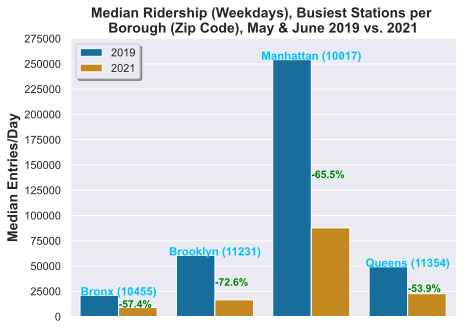

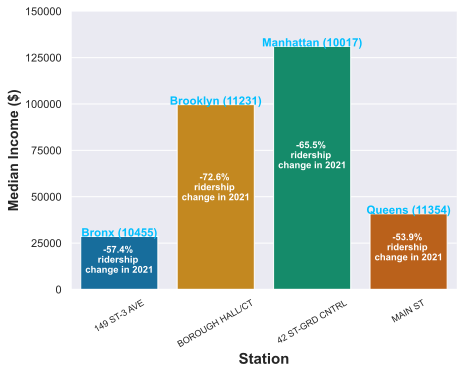

In [663]:
plot_df = plot_df1


sns.set_style("darkgrid")
sns.set_palette("colorblind")

plot = sns.catplot(x='STATION_x', y='MEDIAN_DAILY_ENTRIES', 
                   hue='YEAR', data=plot_df, kind='bar', ci=None,
                   height=4.5, aspect=11.7/8.27, legend_out=False)

plt.title('Median Ridership (Weekdays), Busiest Stations per \nBorough (Zip Code), May & June 2019 vs. 2021', 
          fontdict={'weight': 'bold', 'fontsize': 14})
# plt.xlabel("Station", fontdict={'weight': 'bold', 'size': 15})
# plt.xticks(rotation=30, size=9)
plot.set(xticklabels=[])
plot.set(xlabel=None)
plt.yticks(np.linspace(0, 2.75e5, 12))
plt.ylabel("Median Entries/Day", fontdict={'weight': 'bold', 'size': 14})
plt.legend(loc='upper left', shadow=True)

# This fancy labeling is courtesy of the following StackOverflow post:
#     https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot/55427207
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h, # y coordinate of text
        '{} ({})'.format(plot_df.loc[i, 'BOROUGH'], plot_df.loc[i, 'ZIPCODE']),  # y label
        ha='center', 
        va='baseline', 
        fontweight='bold',
        color='deepskyblue',
        size=11.5)
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h*0.55, # y coordinate of text
        '{}%'.format(plot_df.loc[i, 'PERCENT_CHANGE']),
        ha='left', 
        va='center', 
        fontweight='bold',
        color='green',
        size=10.5)
    if i > 2:
        break
        


        
plot = sns.catplot(x='STATION_x', y='MEDIAN_$_ALL', 
                   data=plot_df1, kind='bar', ci=None,
                   height=4.5, aspect=11.7/8.27)

# plt.title('Median Income in Zip Code, Busiest Stations per \nBorough, May & June 2019 vs. 2021', 
#           fontdict={'weight': 'bold', 'fontsize': 14})
plt.xlabel("Station", fontdict={'weight': 'bold', 'size': 15})
plt.xticks(rotation=30, size=9)
plt.yticks(np.linspace(0, 1.5e5, 7))
plt.ylabel("Median Income ($)", fontdict={'weight': 'bold', 'size': 14})
# plt.legend(loc='upper left', shadow=True)

# This fancy labeling is courtesy of the following StackOverflow post:
#     https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot/55427207
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h, # y coordinate of text
        '{} ({})'.format(plot_df.loc[i, 'BOROUGH'], plot_df.loc[i, 'ZIPCODE']),  # y label
        ha='center', 
        va='baseline', 
        fontweight='bold',
        color='deepskyblue',
        size=11.5)
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h*0.55, # y coordinate of text
        '{}% \nridership \nchange in 2021'.format(plot_df.loc[i, 'PERCENT_CHANGE']),
        ha='center', 
        va='center', 
        fontweight='bold',
        color='white',
        size=9.5)
    if i > 2:
        break;

In [664]:
max_per_borough_weekends = N_thru_M_per_borough(0,0, weekdays=False)

In [665]:
# Figured out how to do courtesy of this post:
#   https://stackoverflow.com/questions/51882279/seaborn-barplot-with-two-y-axis

plot_df2 = pd.melt(max_per_borough_weekends, id_vars=['STATION_x', 'BOROUGH', 'ZIPCODE', 'NET_CHANGE',
                                             'PERCENT_CHANGE', 'MEDIAN_$_ALL'],\
                           var_name='YEAR', value_name='MEDIAN_DAILY_ENTRIES').iloc[32:40].reset_index(drop=True)

In [666]:
plot_df2

,STATION_x,BOROUGH,ZIPCODE,NET_CHANGE,PERCENT_CHANGE,MEDIAN_$_ALL,YEAR,MEDIAN_DAILY_ENTRIES
0,149 ST-3 AVE,Bronx,10455,-6727.5,-61.2,28585,2019,10993.5
1,MYRTLE AVE,Brooklyn,11385,-10779.0,-52.1,75340,2019,20701.0
2,42 ST-GRD CNTRL,Manhattan,10017,-96973.5,-71.0,131045,2019,136617.0
3,ROOSEVELT AVE,Queens,11373,-18433.0,-57.8,54584,2019,31866.0
4,149 ST-3 AVE,Bronx,10455,-6727.5,-61.2,28585,2021,4266.0
5,MYRTLE AVE,Brooklyn,11385,-10779.0,-52.1,75340,2021,9922.0
6,42 ST-GRD CNTRL,Manhattan,10017,-96973.5,-71.0,131045,2021,39643.5
7,ROOSEVELT AVE,Queens,11373,-18433.0,-57.8,54584,2021,13433.0


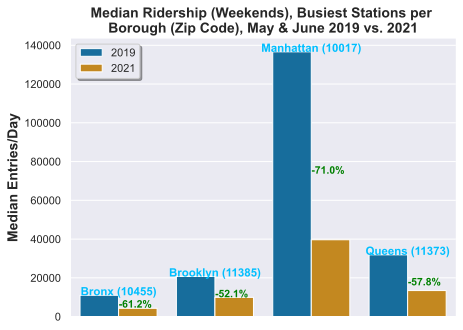

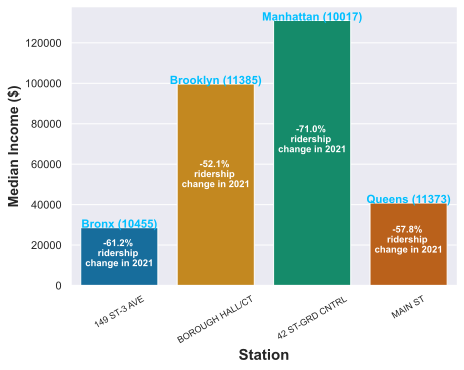

In [667]:
plot_df = plot_df2


sns.set_style("darkgrid")
sns.set_palette("colorblind")

plot = sns.catplot(x='STATION_x', y='MEDIAN_DAILY_ENTRIES', 
                   hue='YEAR', data=plot_df, kind='bar', ci=None,
                   height=4.5, aspect=11.7/8.27, legend_out=False)

plt.title('Median Ridership (Weekends), Busiest Stations per \nBorough (Zip Code), May & June 2019 vs. 2021', 
          fontdict={'weight': 'bold', 'fontsize': 14})
# plt.xlabel("Station", fontdict={'weight': 'bold', 'size': 15})
# plt.xticks(rotation=30, size=9)
plot.set(xticklabels=[])
plot.set(xlabel=None)
# plt.yticks(np.linspace(0, 2.75e5, 12))
plt.ylabel("Median Entries/Day", fontdict={'weight': 'bold', 'size': 14})
plt.legend(loc='upper left', shadow=True)

# This fancy labeling is courtesy of the following StackOverflow post:
#     https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot/55427207
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h, # y coordinate of text
        '{} ({})'.format(plot_df.loc[i, 'BOROUGH'], plot_df.loc[i, 'ZIPCODE']),  # y label
        ha='center', 
        va='baseline', 
        fontweight='bold',
        color='deepskyblue',
        size=11.5)
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h*0.55, # y coordinate of text
        '{}%'.format(plot_df.loc[i, 'PERCENT_CHANGE']),
        ha='left', 
        va='center', 
        fontweight='bold',
        color='green',
        size=10.5)
    if i > 2:
        break
        


        
plot = sns.catplot(x='STATION_x', y='MEDIAN_$_ALL', 
                   data=plot_df1, kind='bar', ci=None,
                   height=4.5, aspect=11.7/8.27)

# plt.title('Median Income in Zip Code, Busiest Stations per \nBorough, May & June 2019 vs. 2021', 
#           fontdict={'weight': 'bold', 'fontsize': 14})
plt.xlabel("Station", fontdict={'weight': 'bold', 'size': 15})
plt.xticks(rotation=30, size=9)
# plt.yticks(np.linspace(0, 1.5e5, 7))
plt.ylabel("Median Income ($)", fontdict={'weight': 'bold', 'size': 14})
# plt.legend(loc='upper left', shadow=True)

# This fancy labeling is courtesy of the following StackOverflow post:
#     https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot/55427207
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h, # y coordinate of text
        '{} ({})'.format(plot_df.loc[i, 'BOROUGH'], plot_df.loc[i, 'ZIPCODE']),  # y label
        ha='center', 
        va='baseline', 
        fontweight='bold',
        color='deepskyblue',
        size=11.5)
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h*0.55, # y coordinate of text
        '{}% \nridership \nchange in 2021'.format(plot_df.loc[i, 'PERCENT_CHANGE']),
        ha='center', 
        va='center', 
        fontweight='bold',
        color='white',
        size=9.5)
    if i > 2:
        break;

### 3b) Let's look at where the most riders have been lost

#### Start with weekdays across all boroughs:

In [492]:
compare_2019_21_weekdays.sort_values(by='NET_CHANGE', ascending=True, inplace=True)
compare_2019_21_weekdays.reset_index(drop=True, inplace=True)

In [691]:
df = compare_2019_21_weekdays.copy()
df['NET_CHANGE'] = -df['NET_CHANGE']

df['NET_CHANGE'].describe()

count       452.000000
mean       7888.259956
std       13858.261970
min         160.000000
25%        2396.750000
50%        4303.500000
75%        8665.000000
max      166392.000000
Name: NET_CHANGE, dtype: float64

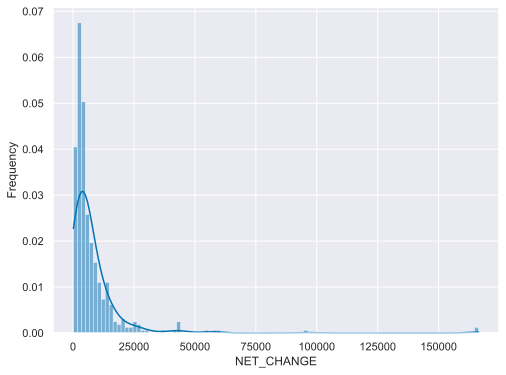

In [701]:
plt.figure(figsize=(8,6))

df = compare_2019_21_weekdays.copy()
df['NET_CHANGE'] = -df['NET_CHANGE']

sns.histplot(x='NET_CHANGE', data=df, kde=True, stat='frequency');

In [633]:
def hbar_plot_lost_riders(df):
    
    plot_df = df.copy()
    plot_df['NET_CHANGE'] = np.abs(plot_df['NET_CHANGE'])
    
    # Need to do this since 'STATION_x' is not unique
    plot_df['NAME'] = plot_df['STATION_x'] + ' (' + plot_df['DIVISION'] \
                             + ' ' + plot_df['COMPLEX_ID'].astype('str') + ')'
    
    # sns.set_style("darkgrid")
    sns.set(rc={'axes.facecolor':'bisque', 'figure.facecolor':'oldlace'})
    sns.set_palette("colorblind")
    plt.figure(figsize=(8,8))
    
    plot = sns.barplot(x='NET_CHANGE', y='NAME', hue='BOROUGH', 
                       data=plot_df,
                       palette ={'Manhattan': 'mediumseagreen', 'Queens': 'mediumslateblue', 
                                 'Brooklyn': 'tomato', 'Bronx': 'fuchsia'},
                       ci=None, dodge=False)
    
    plt.title('  Median Net Loss of Riders (Weekdays), May-June 2021 Relative to 2019 \
              \n(Bar Labels: Median Annual Income in Station Zip Code, %Loss in Riders)', 
              fontdict={'weight': 'bold', 'fontsize': 14})
    plt.xlabel("Net Loss (Riders/Day, Median)", fontdict={'weight': 'bold', 'size': 14})
    plt.yticks(size=9)
    plt.ylabel("Station", fontdict={'weight': 'bold', 'size': 14});
    # plt.legend(loc='upper left', shadow=True)
    
    # This fancy labeling is courtesy of the following StackOverflow post:
    #     https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot/55427207
    for i, bar in enumerate(plot.patches):
        h = bar.get_height()
        plot.text(
            h, # y coordinate of text
            i, # bar index (x coordinate of text)
            '                                    ({}%)' \
                              .format(plot_df.loc[i, 'PERCENT_CHANGE']),  # y label
            ha='left', 
            va='center', 
            fontweight='bold',
            color='aqua',
            size=10)
        plot.text(
            h, # y coordinate of text
            i, # bar index (x coordinate of text)
            '   ${}k ({})'.format(round(plot_df.loc[i, 'MEDIAN_$_ALL']/1000,1), plot_df.loc[i, 'ZIPCODE']),
            ha='left', 
            va='center', 
            fontweight='bold',
            color='gold',
            size=10)
        if i > 28:
            break

#### There are 6 stations with weekday ridership losses of > 50,000 since 2019; let's look at those first

In [634]:
df = compare_2019_21_weekdays[compare_2019_21_weekdays['NET_CHANGE'] <= -50000].reset_index(drop=True)
df.shape

(6, 17)

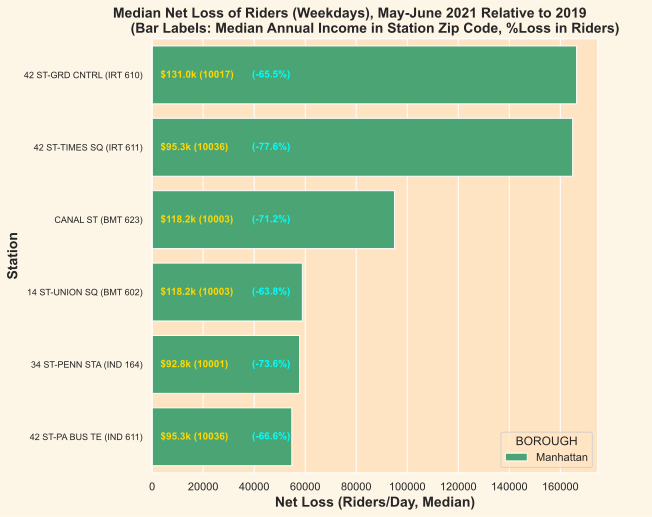

In [635]:
hbar_plot_lost_riders(df)

#### Let's focus on the stations that have lost more than 20,000 weekday riders since 2019:

In [636]:
df = compare_2019_21_weekdays[(compare_2019_21_weekdays['NET_CHANGE'] <= -16600) & 
                              (compare_2019_21_weekdays['NET_CHANGE'] > -50000)].sort_values(by='NET_CHANGE',
                                                                                             ascending=True)
df.reset_index(drop=True, inplace=True)
df.shape

(30, 17)

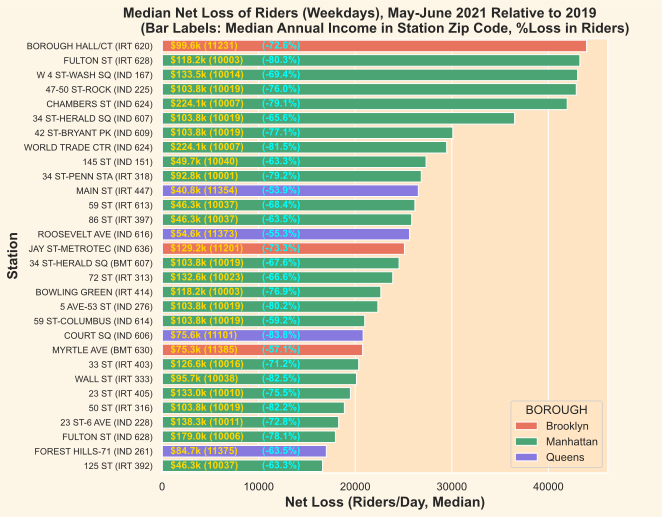

In [637]:
hbar_plot_lost_riders(df)

#### Now look at the next 30 stations' weekday riders losses:

In [638]:
df = compare_2019_21_weekdays[(compare_2019_21_weekdays['NET_CHANGE'] <= -13700) & 
                              (compare_2019_21_weekdays['NET_CHANGE'] > -20000)].sort_values(by='NET_CHANGE',
                                                                                             ascending=True)
df.reset_index(drop=True, inplace=True)
df.shape

(30, 17)

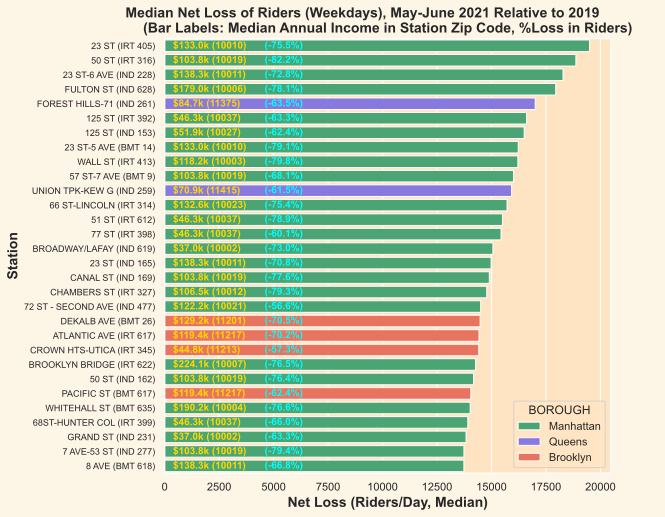

In [639]:
hbar_plot_lost_riders(df)

#### And the next 30 stations' weekday riders losses:

In [640]:
df = compare_2019_21_weekdays[(compare_2019_21_weekdays['NET_CHANGE'] <= -10250) & 
                              (compare_2019_21_weekdays['NET_CHANGE'] > -13700)].sort_values(by='NET_CHANGE',
                                                                                             ascending=True)
df.reset_index(drop=True, inplace=True)
df.shape

(30, 17)

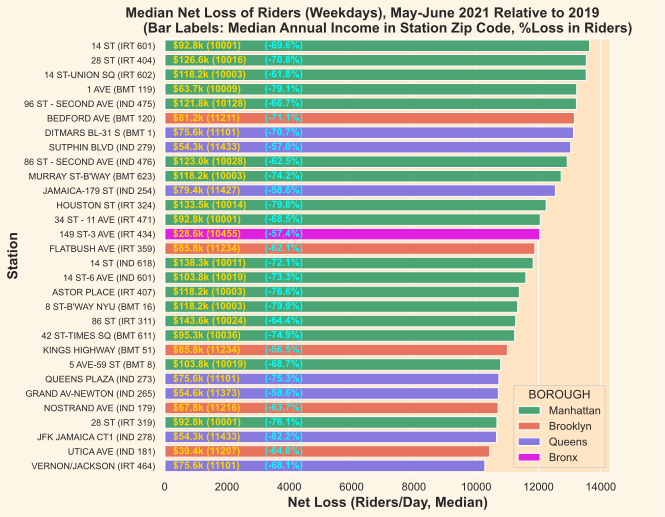

In [641]:
hbar_plot_lost_riders(df)

#### And the next 30 stations' weekday riders losses:

In [642]:
df = compare_2019_21_weekdays[(compare_2019_21_weekdays['NET_CHANGE'] <= -8400) & 
                              (compare_2019_21_weekdays['NET_CHANGE'] > -10250)].sort_values(by='NET_CHANGE',
                                                                                             ascending=True)
df.reset_index(drop=True, inplace=True)
df.shape

(30, 17)

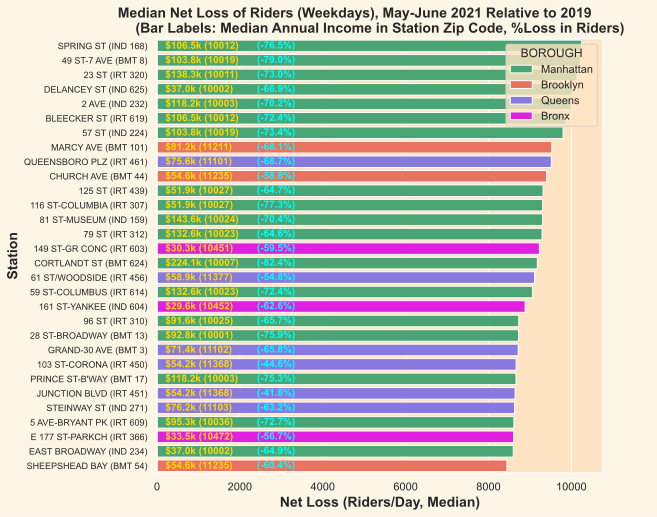

In [643]:
hbar_plot_lost_riders(df)

#### And the next 30 stations' weekday riders losses:

In [644]:
df = compare_2019_21_weekdays[(compare_2019_21_weekdays['NET_CHANGE'] <= -6725) & 
                              (compare_2019_21_weekdays['NET_CHANGE'] > -8400)].sort_values(by='NET_CHANGE',
                                                                                             ascending=True)
df.reset_index(drop=True, inplace=True)
df.shape

(30, 17)

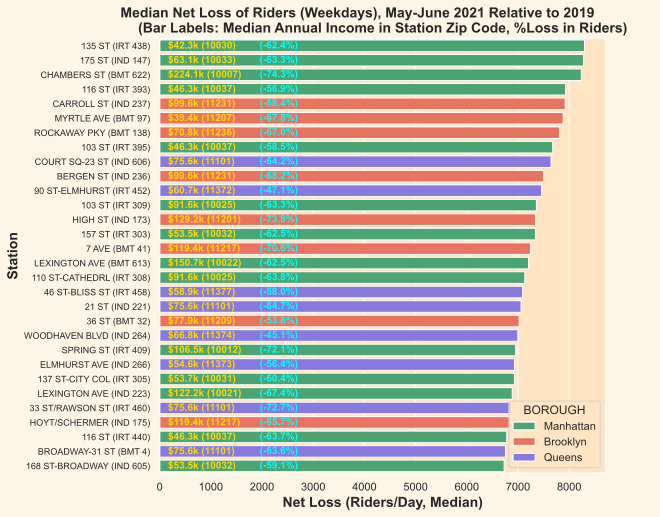

In [645]:
hbar_plot_lost_riders(df)

#### And the next 30 stations' weekday riders losses:

In [646]:
df = compare_2019_21_weekdays[(compare_2019_21_weekdays['NET_CHANGE'] <= -5653) & 
                              (compare_2019_21_weekdays['NET_CHANGE'] > -6725)].sort_values(by='NET_CHANGE',
                                                                                             ascending=True)
df.reset_index(drop=True, inplace=True)
df.shape

(30, 17)

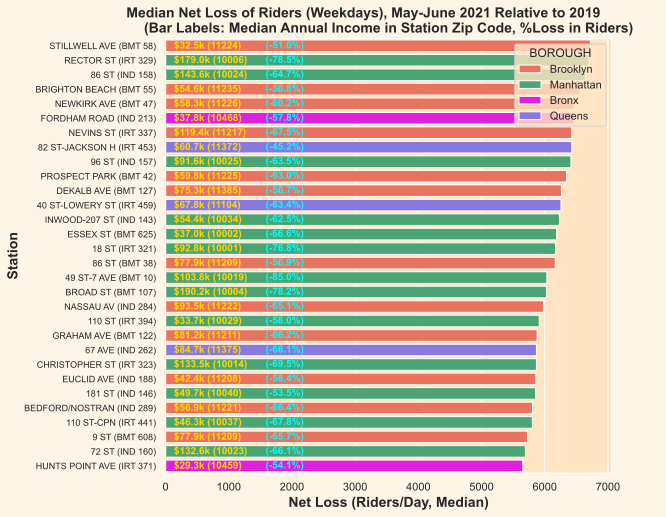

In [647]:
hbar_plot_lost_riders(df)

#### Now let's see the 30 stations with the smallest weekday riders losses:

In [648]:
df = compare_2019_21_weekdays.iloc[-30:]
df.reset_index(drop=True, inplace=True)
df.shape

(30, 17)

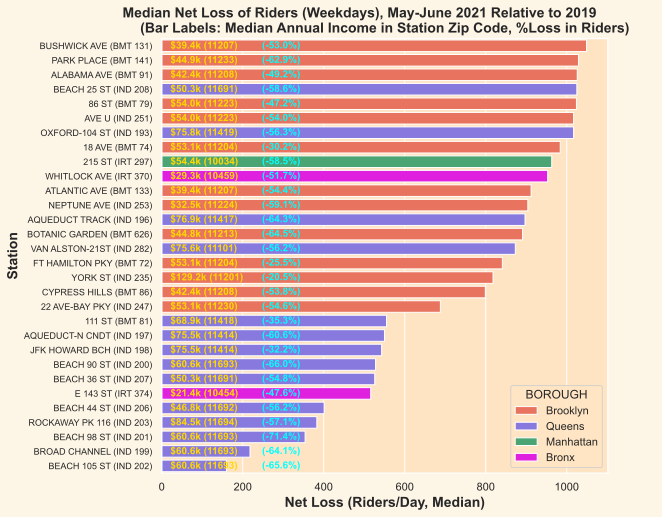

In [649]:
hbar_plot_lost_riders(df)

### 3c) Let's look at some bourough-level details regarding lost rider numbers

In [650]:
compare_2019_21_weekdays.sort_values(by='NET_CHANGE', ascending=True, inplace=True)
compare_2019_21_weekdays.reset_index(drop=True, inplace=True)

In [651]:
compare_2019_21_weekdays.columns

Index(['COMPLEX_ID', 'STATION_x', 'BOROUGH', 'DIVISION', 'LINE_NAME_x',
       'STATION_y', 'STOP_NAME', 'LINE_NAME_y', 'WEEKDAY', 'LINE', 'ZIPCODE',
       '2019', '2021', 'NET_CHANGE', 'PERCENT_CHANGE', 'MEDIAN_$_ALL',
       'MEDIAN_$_FAMILIES'],
      dtype='object')

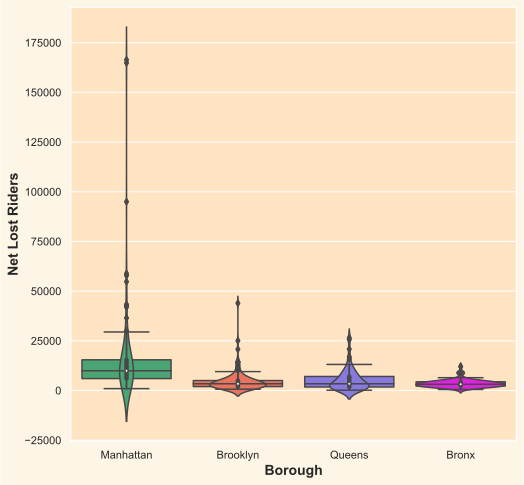

In [773]:
sns.set(rc={'axes.facecolor':'bisque', 'figure.facecolor':'oldlace'})
# sns.set_style('darkgrid')
sns.set_palette("colorblind")
plt.figure(figsize=(8,8))

df = compare_2019_21_weekdays.copy()
df['NET_CHANGE'] = -df['NET_CHANGE']

sns.boxplot(x='BOROUGH', y='NET_CHANGE', data=df,
            palette ={'Manhattan': 'mediumseagreen', 'Queens': 'mediumslateblue', 
                                 'Brooklyn': 'tomato', 'Bronx': 'fuchsia'})

plt.xlabel('Borough', fontdict={'weight': 'bold', 'size': 14})
# plt.yticks(size=9)
plt.ylabel("Net Lost Riders", fontdict={'weight': 'bold', 'size': 14});

sns.violinplot(x='BOROUGH', y='NET_CHANGE', data=df,
            palette ={'Manhattan': 'mediumseagreen', 'Queens': 'mediumslateblue', 
                                 'Brooklyn': 'tomato', 'Bronx': 'fuchsia'})

plt.xlabel('Borough', fontdict={'weight': 'bold', 'size': 14})
# plt.yticks(size=9)
plt.ylabel("Net Lost Riders", fontdict={'weight': 'bold', 'size': 14});

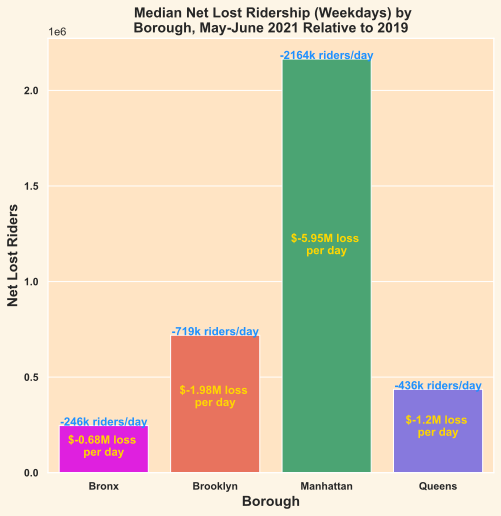

In [767]:
# sns.set_style('dark')
sns.set(rc={'axes.facecolor':'bisque', 'figure.facecolor':'oldlace'})

sns.set_palette("colorblind")
plt.figure(figsize=(8,8))

df = compare_2019_21_weekdays.groupby('BOROUGH')['NET_CHANGE'].sum().reset_index()
df['NET_CHANGE'] = df['NET_CHANGE']*-1

plot = sns.barplot(x='BOROUGH', y='NET_CHANGE', data=df,
            palette ={'Manhattan': 'mediumseagreen', 'Queens': 'mediumslateblue', 
                                 'Brooklyn': 'tomato', 'Bronx': 'fuchsia'})

plt.title('  Median Net Lost Ridership (Weekdays) by \nBorough, May-June 2021 Relative to 2019', 
              fontdict={'weight': 'bold', 'fontsize': 14})
plt.xlabel('Borough', fontdict={'weight': 'bold', 'size': 14})
plt.xticks(size=10.5, weight='bold')
plt.ylabel("Net Lost Riders", fontdict={'weight': 'bold', 'size': 14})
plt.yticks(size=10.5, weight='bold');

# This fancy labeling is courtesy of the following StackOverflow post:
#     https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot/55427207
for i, bar in enumerate(plot.patches):
    h = bar.get_height()
    plot.text(
        i, # bar index (x coordinate of text)
        h, # y coordinate of text
        '-{}k riders/day'.format(round(df.loc[i, 'NET_CHANGE']/1000)),  # y label
        ha='center', 
        va='baseline', 
        fontweight='bold',
        color='dodgerblue',
        size=11.5)
    plot.text(
        i, # bar index (x coordinate of text)
        h*0.55, # y coordinate of text
        '${}M loss \nper day'.format(round(-df.loc[i, 'NET_CHANGE']*2.75/1e6, 2)),
        ha='center', 
        va='center', 
        fontweight='bold',
        color='gold',
        size=11.5)
    if i > 2:
        break;

### 3c) Now let's look at some income-based details about ridership loss

In [705]:
compare_2019_21_weekdays['MEDIAN_$_ALL'].describe()

count       452.000000
mean      71736.949115
std       37851.643260
min       21447.000000
25%       44886.500000
50%       58349.000000
75%       91624.000000
max      224063.000000
Name: MEDIAN_$_ALL, dtype: float64

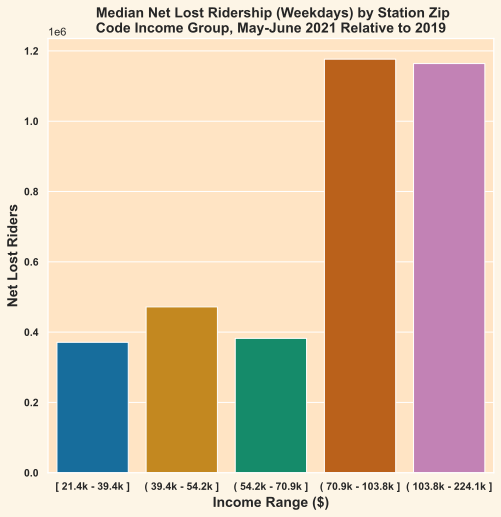

In [766]:
quants = []
for i in range(0, 6, 1):
    quants.append(int(compare_2019_21_weekdays['MEDIAN_$_ALL'].quantile(i*0.2)))

df = compare_2019_21_weekdays.copy()
df['NET_CHANGE'] = df['NET_CHANGE']*-1
df['$_QUANTILE'] = np.nan
df['Q_IDX'] = np.nan

for i in range(0,5):
    if i == 0:
        df.loc[(df['MEDIAN_$_ALL'] >= quants[i]) & 
               (df['MEDIAN_$_ALL'] <= quants[i+1]),'$_QUANTILE'] = \
                        '[ ' + str(round(quants[i]/1000,1)) + 'k - ' + str(round(quants[i+1]/1000,1)) + 'k ]'
        df.loc[(df['MEDIAN_$_ALL'] >= quants[i]) & (df['MEDIAN_$_ALL'] <= quants[i+1]),'Q_IDX'] = i
    else:
        df.loc[(df['MEDIAN_$_ALL'] > quants[i]) & 
               (df['MEDIAN_$_ALL'] <= quants[i+1]),'$_QUANTILE'] = \
                        '( ' + str(round(quants[i]/1000,1)) + 'k - ' + str(round(quants[i+1]/1000,1)) + 'k ]'
        df.loc[(df['MEDIAN_$_ALL'] > quants[i]) & (df['MEDIAN_$_ALL'] <= quants[i+1]),'Q_IDX'] = i
    
df = df.groupby(['Q_IDX', '$_QUANTILE'])['NET_CHANGE'].sum().reset_index()

sns.set(rc={'axes.facecolor':'bisque', 'figure.facecolor':'oldlace'})

sns.set_palette("colorblind")
plt.figure(figsize=(8,8))
plot = sns.barplot(x='$_QUANTILE', y='NET_CHANGE', data=df)

plt.title('  Median Net Lost Ridership (Weekdays) by Station Zip \nCode Income Group, May-June 2021 Relative to 2019', 
              fontdict={'weight': 'bold', 'fontsize': 14})
plt.xlabel('Income Range ($)', fontdict={'weight': 'bold', 'size': 14})
plt.xticks(size=10.5, weight='bold')
plt.ylabel("Net Lost Riders", fontdict={'weight': 'bold', 'size': 14})
plt.yticks(size=10.5, weight='bold');

In [286]:
whos

Variable                             Type         Data/Info
-----------------------------------------------------------
N_thru_M_per_borough                 function     <function N_thru_M_per_borough at 0x7f93ae28d700>
axes                                 ndarray      2: 2 elems, type `object`, 16 bytes
bar                                  Rectangle    Rectangle(xy=(2.6, 0), wi<...>8, height=40786, angle=0)
boroughs                             dict         n=4
compare_2019_21_weekdays             DataFrame         COMPLEX_ID          <...>0569              66250  
compare_2019_21_weekdays_bronx       DataFrame         COMPLEX_ID        ST<...>1447              30076  
compare_2019_21_weekdays_brooklyn    DataFrame         COMPLEX_ID        ST<...>3070              66240  
compare_2019_21_weekdays_manhattan   DataFrame         COMPLEX_ID          <...>4406              56284  
compare_2019_21_weekdays_queens      DataFrame         COMPLEX_ID        ST<...>0569              66250  
comp